In [220]:
!pip install pymongo
from pymongo import MongoClient
import pandas as pd
import pprint
import matplotlib.pyplot as plt

In [203]:
pokedex = MongoClient().pokemon.pokedex
types = MongoClient().pokemon.types

One of Mongo's basic functions is just to fetch the data for a given key. For example, let's say I want all of the data for Charizard. I would run the following command:

In [204]:
pprint.pprint(pokedex.find_one({'name': {'language':'english', 'language name':'Charizard', }}))

{'_id': ObjectId('63f7f165627b4b80698b7908'),
 'base': {'Attack': 84,
          'Defense': 78,
          'HP': 78,
          'Sp': {' Attack': 109, ' Defense': 85},
          'Speed': 100},
 'id': 6,
 'name': [{'language': 'english', 'language name': 'Charizard'},
          {'language': 'japanese', 'language name': 'リザードン'},
          {'language': 'chinese', 'language name': '喷火龙'},
          {'language': 'french', 'language name': 'Dracaufeu'}],
 'type': ['Fire', 'Flying']}


Now, say I want the names of all the pokemon Charizard has a type advantage over. This means I need to know what pokemon have any weakness that exist in Charizard's type. To find those pokeomn, I can run the following commands:  

In [205]:
char_types = pokedex.find_one({'name': {'language':'english', 'language name':'Charizard', }})['type']
weak_types = set()
for char_type in char_types:
    for weak_type in [name['name'] for name in types.find({'weaknesses': char_type}, {'name': 1})]:
        weak_types.add(weak_type)
weak_pkmn = [pkmn['name'][0]['language name'] for pkmn in pokedex.find({'type': {'$in': [elem for elem in weak_types]}})]
print(weak_pkmn[:15])

    

['Bulbasaur', 'Ivysaur', 'Venusaur', 'Charmander', 'Charmeleon', 'Charizard', 'Caterpie', 'Metapod', 'Butterfree', 'Weedle', 'Kakuna', 'Beedrill', 'Clefairy', 'Clefable', 'Vulpix']


Now, let's say I want to find all the pokemon Charizard has a type disadvantage to. I need to find pokemon with a type existing in Charizard's weaknesses. To do that, I can use the following command:

In [206]:
char_types = pokedex.find_one({'name': {'language':'english', 'language name':'Charizard', }})['type']
strong_types = set()
for char_type in char_types:
    for strong_type in [name['name'] for name in types.find({'strengths': char_type}, {'name': 1})]:
        strong_types.add(strong_type)
strong_pkmn = [pkmn['name'][0]['language name'] for pkmn in pokedex.find({'type': {'$in': [elem for elem in strong_types]}})]
print(strong_pkmn[:15])


['Squirtle', 'Wartortle', 'Blastoise', 'Pikachu', 'Raichu', 'Sandshrew', 'Sandslash', 'Nidoqueen', 'Nidoking', 'Diglett', 'Dugtrio', 'Psyduck', 'Golduck', 'Poliwag', 'Poliwhirl']


Now for something simpler. Let's say I have a solid pokemon team but I'm missing a Water Type. To get all of the possible water types, I can run the following command:

In [207]:
water_pkmn = pokedex.find({'type': 'Water'})
for pkmn in water_pkmn[:15]:
    print(pkmn['name'][0]['language name'])

Squirtle
Wartortle
Blastoise
Psyduck
Golduck
Poliwag
Poliwhirl
Poliwrath
Tentacool
Tentacruel
Slowpoke
Slowbro
Seel
Dewgong
Shellder


Now, Say that I don't just want a water type. I want a water type sweeper, which is a pokemon with high speed and either high special or physical attack stats. So, I can query for water types with high speed and special attack or high speed and physical attack with the following commands:

In [225]:
spc_sweepers = pokedex.find({'$or': [{'base.Attack': {'$gt': 100}}, {'base.Sp. Attack': {'$gt': 100}}], 
                             'base.Speed': {'$gt': 100}, 'type': 'Water', })


for pkmn in spc_sweepers:
    pprint.pprint(pkmn)

{'_id': ObjectId('63f7f165627b4b80698b7aa5'),
 'base': {'Attack': 105,
          'Defense': 55,
          'HP': 85,
          'Sp': {' Attack': 85, ' Defense': 50},
          'Speed': 115},
 'id': 419,
 'name': [{'language': 'english', 'language name': 'Floatzel'},
          {'language': 'japanese', 'language name': 'フローゼル'},
          {'language': 'chinese', 'language name': '浮潜鼬'},
          {'language': 'french', 'language name': 'Mustéflott'}],
 'type': ['Water']}
{'_id': ObjectId('63f7f165627b4b80698b7b89'),
 'base': {'Attack': 72,
          'Defense': 90,
          'HP': 91,
          'Sp': {' Attack': 129, ' Defense': 90},
          'Speed': 108},
 'id': 647,
 'name': [{'language': 'english', 'language name': 'Keldeo'},
          {'language': 'japanese', 'language name': 'ケルディオ'},
          {'language': 'chinese', 'language name': '凯路迪欧'},
          {'language': 'french', 'language name': 'Keldeo'}],
 'type': ['Water', 'Fighting']}
{'_id': ObjectId('63f7f165627b4b80698b7b94'),
 

Now, let's say I'm looking for the best types of pokemon to be a tank. Tanks are pokemon with high HP and either high special defense or defense. To find the pokemon types best suited to be a tank, I can run the following command:

['Steel', 'Rock', 'Dragon', 'Ice', 'Psychic']


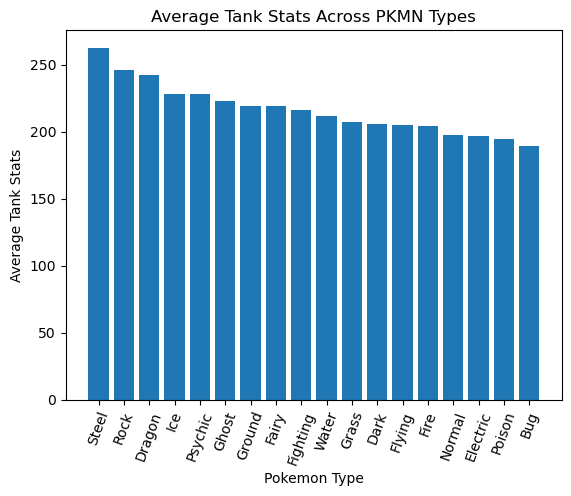

In [226]:
tank_types = []
stat_avgs = {}
for elem in pokedex.aggregate([{'$project': {
                                            'stat sum': {
                                                        '$add':[
                                                                '$base.HP',  
                                                                '$base.Defense', 
                                                                '$base.Sp. Defense']}, 
                                            'type': 1}},
                                {'$unwind': '$type'}, 
                                {'$group': {
                                          '_id': '$type', 
                                          'stat avg': {
                                                      '$avg': '$stat sum'}}},
                                {'$sort': {
                                        'stat avg': -1}}]):
    
    tank_types.append(elem['_id'])
    stat_avgs[elem['_id']] = elem['stat avg']
print(tank_types[:5])
plt.bar(stat_avgs.keys(), stat_avgs.values())
plt.title('Average Tank Stats Across PKMN Types')
plt.xlabel('Pokemon Type')
plt.ylabel('Average Tank Stats')
plt.xticks(rotation=70)
plt.savefig('pkmn_tank_stats.png')
plt.show()



There are a few intersting things to note from the above graph. First, normal types are considered excellent tanks in the pokemon community because of their type resistances and representative pokemon like Snorlax and Milktank which are excellent tanks. However, on average, normal type pokemon are ranked very low in terms of their tank stats. Another unexpected thing this graph reveals is that ice type pokemon are surprising good tanks. In thepokemon community, ice types are considered glass cannons because of their type weaknesses and their representation in competitive pokemon gameplay. however, ice types are ranked fourth in terms of their tank stats. 

Now let's say I want to find the best tank pokemon for each of those types. To do that, I need to find pokemon of those types with the highest HP, Defense, and Special Defense. To do that, I can run the following commands:

In [210]:
for elem in pokedex.aggregate([{'$unwind': '$type'},
                               {'$match': {
                                            'type': {'$in': tank_types[:3]}}},
                               {'$project': {'avg tank stat': 
                                                            {'$avg': [
                                                                    '$base.HP', 
                                                                    '$base.Defense', 
                                                                    '$base.Sp. Defense']},
                                            'type': 1,
                                            'name': 1}},
                               {'$group': {
                                          '_id': '$type',
                                          'items': {
                                                  '$push': '$$CURRENT'},
                                          'max tank stat': {
                                                            '$max': '$avg tank stat'}}},
                              {'$project': {  
                                        'max tank stat': 1, 
                                        'name': { 
                                                  '$map': { 
                                                        'input': { 
                                                              '$filter': { 
                                                                        'input': '$items', 'as': 'i', 
                                                                        'cond': { 
                                                                               '$eq': [ '$$i.avg tank stat', '$max tank stat' ]}}}, 
                                                        'in': '$name' }}}}]):
    pkmn_type = elem['_id']
    pkmn_tank_stat = elem['max tank stat']
    for pkmn in pokedex.aggregate([{'$match': {'type': {'$in': [pkmn_type]}}},
                      {'$project': {'avg tank stat': 
                                                            {'$avg': [
                                                                    '$base.HP', 
                                                                    '$base.Defense', 
                                                                    '$base.Sp. Defense']},
                                            'type': 1,
                                            'name': 1}},
                      {'$match': {'avg tank stat': {'$eq': pkmn_tank_stat}}}]):
        print(pkmn['name'][0]['language name'])
    
    

Giratina
Shuckle
Registeel


Let's Say I want to play a game with a team all of one pokemon type, so I want to know the strongest pokemon type on average. To determine that, I need to sum all the pokemon's individual stats, aggregate by type with an agg function of mean, sort the types in descending order of average stats, and then pick the first result. To do that, I can run the following command: 

In [211]:
for elem in pokedex.aggregate([{'$project': {
                                            'stat sum': {
                                                        '$add':[
                                                                '$base.HP', 
                                                                '$base.Speed', 
                                                                '$base.Attack', 
                                                                '$base.Defense',
                                                                '$base.Sp. Attack', 
                                                                '$base.Sp. Defense']}, 
                                            'type': 1}},
                                {'$unwind': '$type'}, 
                                {'$group': {
                                          '_id': '$type', 
                                          'stat avg': {
                                                      '$avg': '$stat sum'}}},
                                {'$sort': {
                                        'stat avg': -1}}, 
                                {'$limit': 1}]):
    
    
    print(elem)

{'_id': 'Dragon', 'stat avg': 496.97777777777776}


Mongo can also insert data programmatically. Let's say the Pokemon Company has introduced a new pokemon type with their latest game. Imagine a frenetic pokemon type that is strong against psychic, dark, and fighting types, weak against normal, bug, and fairy types, and immune to normal types. to insert this new type into the types collection, I can run the following command:

In [212]:
types.insert_one({"name":"Frenetic","immunes":['Normal'],"weaknesses":["Normal","Bug","Fairy", 'Frenetic'],
                  "strengths":["Fighting","Psychic","Dark"]})

# to verify it was added to the collection
[pprint.pprint(elem) for elem in types.find({'name': 'Frenetic'})]


{'_id': ObjectId('63f95df48bc87e4668ac8981'),
 'immunes': ['Normal'],
 'name': 'Frenetic',
 'strengths': ['Fighting', 'Psychic', 'Dark'],
 'weaknesses': ['Normal', 'Bug', 'Fairy', 'Frenetic']}


[None]

The issue with just adding a type is that we have yet to add that type to other type's strengths and weaknesses. To do that, I can run the following commands:

In [213]:
# update other pkmn weaknesses
types.update_many({'name': {'$in': types.find_one({'name': 'Frenetic'})['strengths']}}, {'$push': \
                                                                                         {'weaknesses': 'Frenetic'}})

# update other pkmn strengths
types.update_many({'name': {'$in': types.find_one({'name': 'Frenetic'})['weaknesses']}}, {'$push': \
                                                                                          {'strengths': 'Frenetic'}})

# to verify other pkmn were altered, test a fairy type and a fighting type
[pprint.pprint(elem) for elem in types.find({'name': 'Fairy'})]
[pprint.pprint(elem) for elem in types.find({'name': 'Fighting'})]



{'_id': ObjectId('63f95d5e627b4b80698b7c3e'),
 'immunes': [],
 'name': 'Fairy',
 'strengths': ['Fighting', 'Dragon', 'Dark', 'Frenetic'],
 'weaknesses': ['Fire', 'Poison', 'Steel']}
{'_id': ObjectId('63f95d5e627b4b80698b7c33'),
 'immunes': ['Ghost'],
 'name': 'Fighting',
 'strengths': ['Normal', 'Ice', 'Rock', 'Dark', 'Steel'],
 'weaknesses': ['Poison', 'Flying', 'Psychic', 'Bug', 'Fairy', 'Frenetic']}


[None]